<a href="https://colab.research.google.com/github/pyon0615/Pocket-Physio/blob/main/Model1_imageclass_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Video to images - more data for the data god
import cv2
vidcap = cv2.VideoCapture('big_buck_bunny_720p_5mb.mp4')
success,image = vidcap.read()
count = 0
while success:
  cv2.imwrite("frame%d.jpg" % count, image)     # save frame as JPEG file
  success,image = vidcap.read()
  print('Read a new frame: ', success)
  count += 1

# 1. Set up and load data

In [ ]:
import tensorflow as tf
import os
#os means operating system e.g. os.path.join('data') OR os.listdir('data')

**Avoid OOM errors by setting GPU Memory Consumption Growth:**
gpus = tf.config.experimental.list_physical_devices('GPU') --> THIS says what GPUs are on your device
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
--> THIS limits how much memory tensor flow can use

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
from google.colab import files
uploaded = files.upload()

import zipfile
import os

with zipfile.ZipFile("Edited_data.zip", 'r') as zip_ref:
    zip_ref.extractall("exercise_data")  # Extracts into folder-

Saving Edited_data.zip to Edited_data.zip


In [3]:
os.listdir('exercise_data/Training_data')

['squat', 'push up']

In [4]:
import numpy as np
from matplotlib import pyplot as plt

dataset = tf.keras.utils.image_dataset_from_directory('exercise_data/Training_data')
#labels='inferred',label_mode='int', class_names=None, color_mode='rgb', batch_size=32, image_size=(256, 256),
#shuffle=True, seed=None, validation_split=None, ect

Found 1752 files belonging to 2 classes.


In [5]:
data_iterator = dataset.as_numpy_iterator()
batch = data_iterator.next() #Getting batch
batch[1]

array([0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0,
       0, 1, 0, 0, 1, 1, 0, 1, 1, 0], dtype=int32)

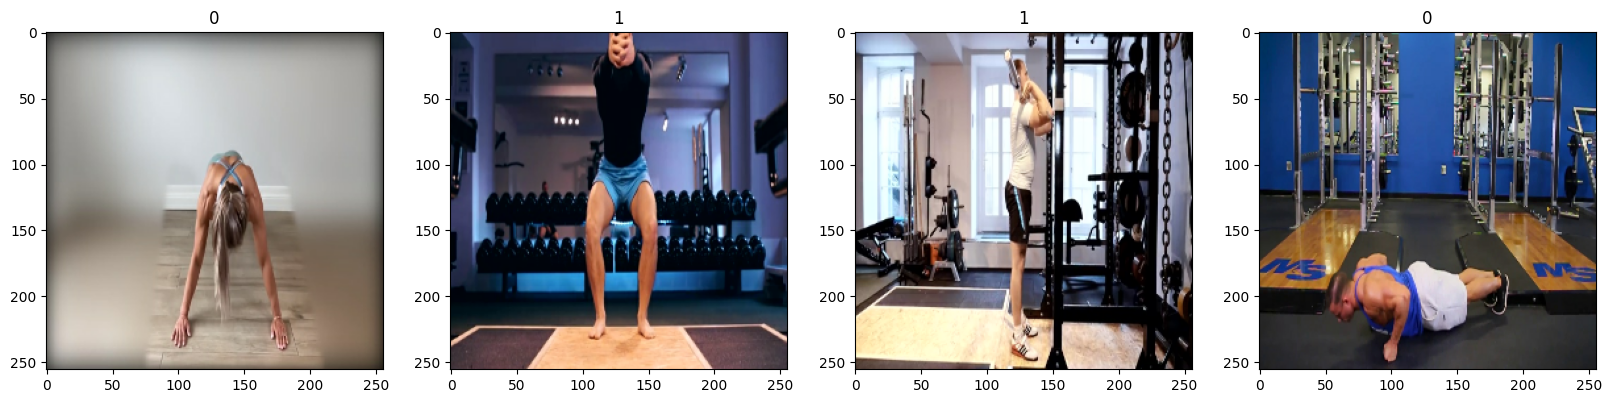

In [6]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])
#Opening batch

# 2 - Preprocessing, data augmentation and splitting

In [7]:
#Rescale pixels from 0-1
dataset2 = dataset.map(lambda x,y: (x/255, y))
dataset2.as_numpy_iterator().next()

(array([[[[0.9996515 , 0.9996515 , 0.99180835],
          [0.9982269 , 0.9982269 , 0.99038374],
          [0.99607843, 0.99607843, 0.99607843],
          ...,
          [0.51307064, 0.59615886, 0.4253255 ],
          [0.850494  , 0.9123162 , 0.7941138 ],
          [0.61106   , 0.67023206, 0.5825061 ]],
 
         [[0.9993298 , 0.9993298 , 0.99626607],
          [0.99846816, 0.99846816, 0.9954044 ],
          [0.99607843, 0.99607843, 0.99607843],
          ...,
          [0.32095206, 0.4088197 , 0.2351486 ],
          [0.63336396, 0.70450366, 0.5765242 ],
          [0.48623237, 0.5539407 , 0.45247397]],
 
         [[1.        , 1.        , 1.        ],
          [0.99998087, 0.99998087, 1.        ],
          [0.9952819 , 0.9952819 , 0.9954044 ],
          ...,
          [0.3601256 , 0.44724646, 0.29106924],
          [0.63907397, 0.72005975, 0.6008157 ],
          [0.69965535, 0.7747166 , 0.6753293 ]],
 
         ...,
 
         [[0.5261987 , 0.58496094, 0.6048139 ],
          [0.51274

In [8]:
# Define data augmentation layers (real-time)
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.05),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1)
])

#Apply augmentation (training only)
dataset3 = dataset2.map(lambda x, y: (data_augmentation(x, training=True), y))

#Prefetch for performance
dataset3 = dataset3.prefetch(buffer_size=tf.data.AUTOTUNE)

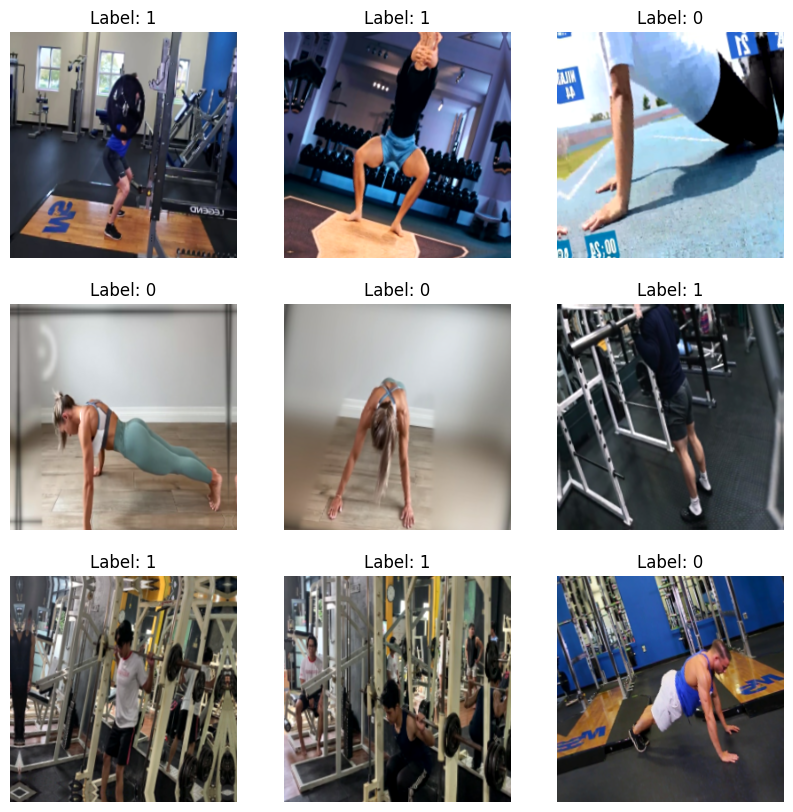

In [9]:
import matplotlib.pyplot as plt

for images, labels in dataset3.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(f"Label: {labels[i].numpy()}")
        plt.axis("off")
    break

In [10]:
# CHAT:
# Count total batches
total_batches = tf.data.experimental.cardinality(dataset3).numpy()
val_batches = int(0.2 * total_batches)

# Split
val_ds = dataset3.take(val_batches)
train_ds = dataset3.skip(val_batches)

In [11]:
#Bald jesus
#len(dataset3)
#train_size = int(len(dataset3)*.7)
#val_size = int(len(dataset3)*.2)
#test_size = int(len(dataset3)*.1)
#train_size

In [12]:
#Bald jesus:
#train = dataset3.take(train_size)
#Val = dataset3.skip(train_size).take(val_size)
#test = dataset3.skip(train_size+val_size).take(test_size)

# Model Building


In [13]:
from tensorflow.keras import layers, models

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(256, 256, 3)),

    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(2, activation='softmax')  # 2 classes
])

In [14]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [15]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 55s 896ms/step - accuracy: 0.7098 - loss: 0.7720 - val_accuracy: 0.9744 - val_loss: 0.0850
Epoch 2/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 70s 755ms/step - accuracy: 0.9709 - loss: 0.0844 - val_accuracy: 0.9858 - val_loss: 0.0404
Epoch 3/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 43s 832ms/step - accuracy: 0.9664 - loss: 0.0770 - val_accuracy: 0.9858 - val_loss: 0.0574
Epoch 4/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 40s 757ms/step - accuracy: 0.9879 - loss: 0.0416 - val_accuracy: 0.9574 - val_loss: 0.1019
Epoch 5/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 43s 821ms/step - accuracy: 0.9778 - loss: 0.0873 - val_accuracy: 0.9858 - val_loss: 0.0563
Epoch 6/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 43s 817ms/step - accuracy: 0.9869 - loss: 0.0452 - val_accuracy: 0.9915 - val_loss: 0.0218
Epoch 7/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 47s 822ms/step - accuracy: 0.9876 - loss: 0.0484 - val_accuracy: 0.9943 - val_loss: 0.0237
Epoch 8/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 40s 768ms/step - accuracy: 0.9910 - loss: 0.0212 - val_accu

In [16]:
model.save('model3.keras')

# Evaluation metrics

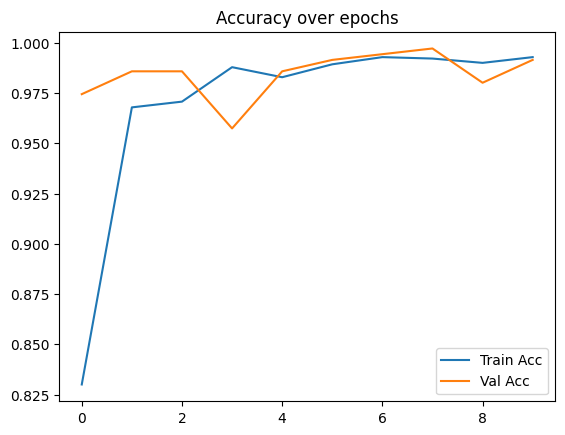

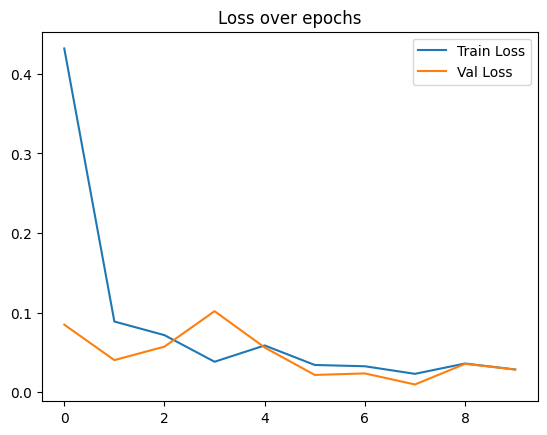

In [17]:
import matplotlib.pyplot as plt

# Accuracy over epochs
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Accuracy over epochs")
plt.show()

# Loss over epochs
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


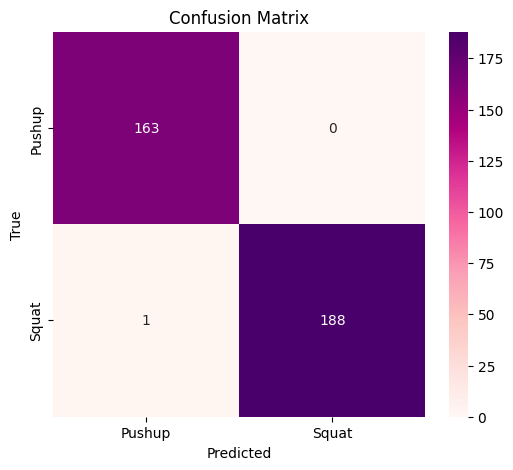

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#Get true vs predicted labels for VALIDATION SET
y_true = []
y_pred = []

for images, labels in val_ds:
    y_true.extend(labels.numpy())
    predictions = model.predict(images)
    y_pred.extend(np.argmax(predictions, axis=1))

cm = confusion_matrix(y_true, y_pred)
class_names = ['Pushup', 'Squat']

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='RdPu', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


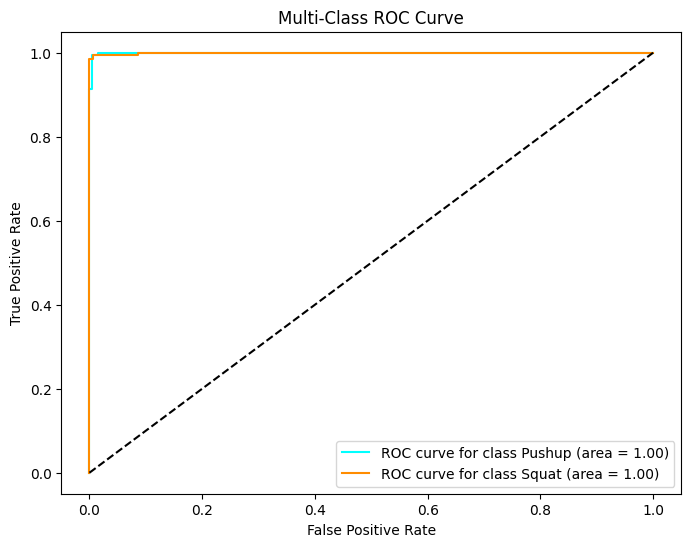

In [21]:
#AUC curve
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

# For ROC, we need one-hot labels and predicted probabilities
y_score = []
y_true_onehot = []

for images, labels in val_ds:
    y_score_batch = model.predict(images)
    y_score.extend(y_score_batch)
    y_true_onehot.extend(tf.one_hot(labels, depth=2).numpy())

y_score = np.array(y_score)
y_true_onehot = np.array(y_true_onehot)

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_true_onehot[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC
plt.figure(figsize=(8, 6))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple'])
for i, color in zip(range(2), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label=f'ROC curve for class {class_names[i]} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # random chance
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc='lower right')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


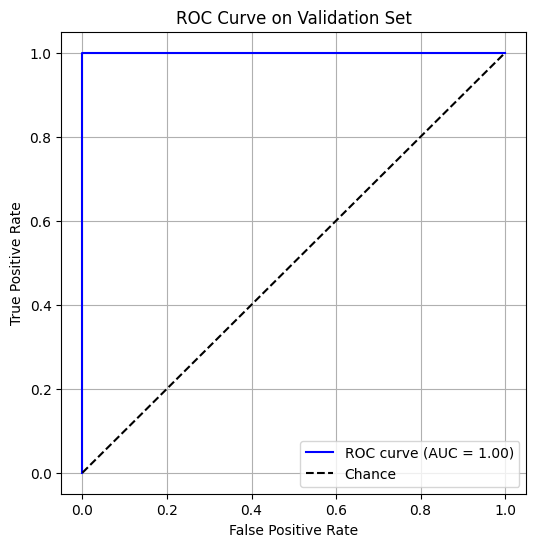

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Step 1: Collect true labels and predicted probabilities
y_true = []
y_scores = []

for images, labels in val_ds:
    probs = model.predict(images)  # model outputs probabilities

    # If softmax with 2 units: take prob of class 1
    if probs.shape[1] == 2:
        scores = probs[:, 1]  # class 1 (positive class)
    else:  # sigmoid output (Dense(1, activation='sigmoid'))
        scores = probs[:, 0]

    y_scores.extend(scores)
    y_true.extend(labels.numpy())

# Step 2: Compute ROC and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Step 3: Plot
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})", color='blue')
plt.plot([0, 1], [0, 1], 'k--', label="Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve on Validation Set")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# test on unseen images - inference

In [24]:
#Import dependencies
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
from PIL import Image
import numpy as np
import tensorflow as tf
import cv2
import io

In [25]:
#Define variable
IMG_SIZE = (256, 256)
CLASS_NAMES = ['push_up', 'squat']
MODEL_PATH = 'model3.keras'

#Load model
model = tf.keras.models.load_model(MODEL_PATH)

In [45]:
# Preprocess image
img = PIL.Image.open('push up.jpg').convert('RGB')
img = img.resize((256, 256))
img_array = np.array(img) / 255.0  # Normalize
img_tensor = np.expand_dims(img_array, axis=0)  # Add batch dimension

# make predictions
preds = model.predict(img_tensor)
pred_class = CLASS_NAMES[np.argmax(preds)]
confidence = np.max(preds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


In [46]:
float(confidence*100)

99.9984359741211

✅ Prediction: push_up (100.00%)


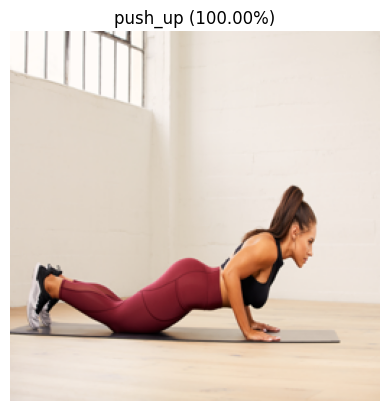

In [47]:
# display results
if float(confidence*100) > 50:
    print(f"✅ Prediction: {pred_class} ({confidence*100:.2f}%)")
else:
    print(f"❌ Uncertain")

# Display image
import matplotlib.pyplot as plt
plt.imshow(img)
plt.title(f"{pred_class} ({confidence*100:.2f}%)")
plt.axis('off')
plt.show()

# Chat: image capture and classification

In [48]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
import io

def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript(f'''
        async function takePhoto(quality) {{
            // Clean up previous webcam elements if they exist
            const oldDiv = document.getElementById('webcam-container');
            if (oldDiv) {{
                oldDiv.remove();
            }}

            const div = document.createElement('div');
            div.id = 'webcam-container';

            const capture = document.createElement('button');
            capture.textContent = '📷 Capture';
            capture.style.fontSize = '18px';
            div.appendChild(capture);

            const video = document.createElement('video');
            video.style.display = 'block';
            video.style.marginTop = '10px';
            video.style.maxWidth = '100%';
            div.appendChild(video);

            document.body.appendChild(div);

            const stream = await navigator.mediaDevices.getUserMedia({{video: true}});
            video.srcObject = stream;
            await video.play();

            google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

            await new Promise((resolve) => capture.onclick = resolve);

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);

            stream.getTracks().forEach(track => track.stop());
            div.remove();

            const dataUrl = canvas.toDataURL('image/jpeg', quality);
            return dataUrl;
        }}
        takePhoto({quality});
    ''')

    display(js)
    data = eval_js(f"takePhoto({quality})")
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename

In [55]:
print("📷 Capture an image from your webcam")
image_path = take_photo()

📷 Capture an image from your webcam


<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
✅ Prediction: push_up (61.70%)


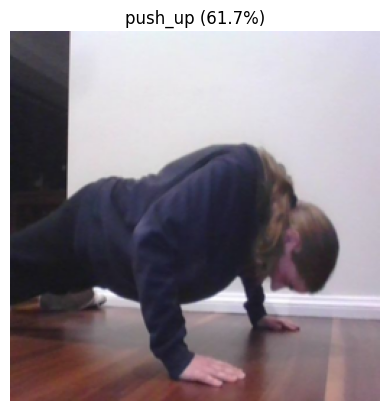

In [56]:

# === Step 5: Preprocess image ===
img = Image.open(image_path).convert('RGB')
img = img.resize(IMG_SIZE)
img_array = np.array(img) / 255.0  # Normalize
img_tensor = np.expand_dims(img_array, axis=0)  # Add batch dimension

# === Step 6: Predict ===
preds = model.predict(img_tensor)
pred_class = CLASS_NAMES[np.argmax(preds)]
confidence = np.max(preds)

# === Step 7: Display result ===
print(f"✅ Prediction: {pred_class} ({confidence*100:.2f}%)")

# Optional: Display image
import matplotlib.pyplot as plt
plt.imshow(img)
plt.title(f"{pred_class} ({confidence*100:.1f}%)")
plt.axis('off')
plt.show()